# Biodiversity Project

# Introduction

For this project I will be a biodiversity analyst working for the National Parks Service.  I'm going to help them analyse some data about species at various national parks.

Note: The data that I'll be working with for this project is *inspired* by real data, but is mostly fictional.

# Step 1


In [59]:
from matplotlib import pyplot as plt
import pandas as pd

# Step 2

Let's inspect the CSV files with data about different species in our National Parks, including:
- The scientific name of each species
- The common names of each species
- The species conservation status


In [60]:
species = pd.read_csv('species_info.csv')

In [61]:
print(species.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  


# Step 3

Let's start by learning a bit more about the data and answer each of the following questions.

How many different species are in the `species` DataFrame?

In [62]:
print(species.category.count())

5824


What are the different values of `category` in `species`?

In [63]:
print(species.category.unique())

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


What are the different values of `conservation_status`?

In [64]:
print(species.conservation_status)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
5819    NaN
5820    NaN
5821    NaN
5822    NaN
5823    NaN
Name: conservation_status, Length: 5824, dtype: object


# Step 4



The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range

I'd like to count up how many species meet each of these criteria.  

In [65]:
protection_counts = species.groupby('conservation_status').scientific_name.count().reset_index()
print(protection_counts)

  conservation_status  scientific_name
0          Endangered               16
1         In Recovery                4
2  Species of Concern              161
3          Threatened               10


As we saw before, there are far more than 200 species in the `species` table.  Clearly, only a small number of them are categorized as needing some sort of protection.  The rest have `conservation_status` equal to `None`.  Because `groupby` does not include `None`, we will need to fill in the null values.  



In [66]:
protection_counts = species.fillna('No Intervention', inplace=True)

Now I'll run the same `groupby` as before to see how many species require `No Intervention`.

In [71]:
protection_counts = species.groupby('conservation_status').scientific_name.count().sort_values().reset_index()
protection_counts.columns = ['conservation_status', 'number_of_species']
print(protection_counts)

  conservation_status  number_of_species
0         In Recovery                  4
1          Threatened                 10
2          Endangered                 16
3  Species of Concern                161
4     No Intervention               5633


Now I'll visualise this information

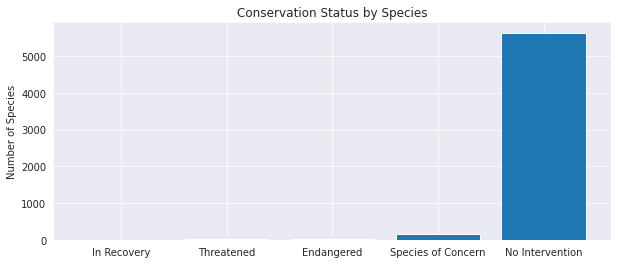

In [72]:
plt.figure(figsize=(10, 4))
ax = plt.subplot()
plt.bar(range(len(protection_counts)),
        protection_counts.number_of_species.values)
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status.values)
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
plt.show()


# Step 5

Let's see if certain types of species are more likely to be endangered

Creating a new column with protected species

In [ ]:
species['is_protected'] = (species.conservation_status != 'No Intervention')


Let's group the `species` data frame by the `category` and `is_protected` columns and count the unique `scientific_name`s in each grouping.



In [ ]:

category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index()

In [ ]:
print(category_counts.head())

It's going to be easier to view this data if we pivot it.  

In [ ]:
category_pivot = category_counts.pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                                .reset_index()

In [ ]:
print(category_pivot.head())

Renaming columns

In [ ]:
category_pivot.columns = ['category', 'not_protected', 'protected' ]


Let's create a new column of `category_pivot` called `percent_protected`.

In [ ]:
category_pivot['percent_protected'] = category_pivot.protected/ (category_pivot.protected + category_pivot.not_protected)

In [ ]:
print(category_pivot)
category_pivot.to_csv('category_pivot.png')

It looks like species in category `Mammal` are more likely to be endangered than species in `Bird`.  I'm going to do a significance test to see if this statement is true. 

Since the data is categorical and I want to compare two species, I'm going to do a *chi squared test*.  In order to run a chi squared test, we'll need to create a contingency table.  

In [ ]:
contingency = [[30, 146], [75, 413]]

In [ ]:
from scipy.stats import chi2_contingency

Now let's run `chi2_contingency` with `contingency`.

In [ ]:
chi , pval, dof, expected = chi2_contingency(contingency)
print(pval)

It looks like this difference isn't significant because the p- value is greater then 0.05!

Let's test if the difference between `Reptile` and `Mammal` is significant.

In [ ]:
contingency2 = [[30, 146], [5, 73]]
chi , pval, dof, expected = chi2_contingency(contingency2)
print(pval)

Yes! It looks like there is a significant difference between `Reptile` and `Mammal`!

# Step 6

Conservationists have been recording sightings of different species at several national parks for the past 7 days and stored their observations in a file called `observations.csv`. 

In [ ]:
observations = pd.read_csv('observations.csv')
print(observations.head())

Let's study the number of sheep sightings at different national parks. There are several different scientific names for different types of sheep.  I'm going to find which rows of `species` are referring to sheep. 

In [ ]:
species['is_sheep'] = species.common_names.apply(lambda x:'Sheep' in x )

In [ ]:
sheep= species[species.is_sheep == True]
print(sheep)

Many of the results are actually plants.  I'll select the rows of `species` where `is_sheep` is `True` and `category` is `Mammal`.

In [ ]:
sheep_species = sheep[sheep.category == 'Mammal']


Now I'll merge `sheep_species` with `observations` to get a DataFrame with observations of sheep.

In [ ]:
sheep_observations = observations.merge(sheep_species)

print(sheep_observations)
 

I'm going to fing how many total sheep observations (across all three species) were made at each national park.
This is the total number of sheep observed in each park over the past 7 days.

In [ ]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum().reset_index()
obs_by_park.columns =['park_name', 'observations']
print(obs_by_park)

Let's visualise it. 

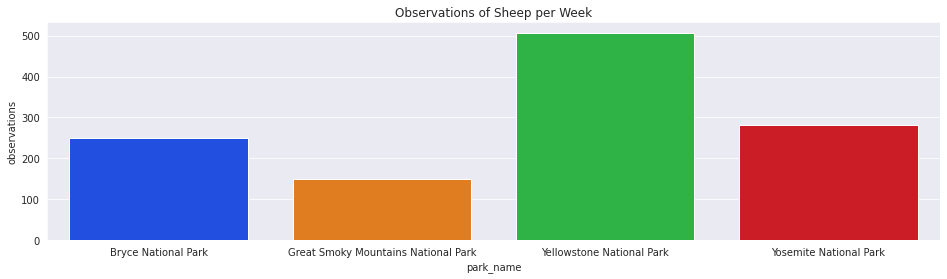

In [73]:
import seaborn as sns
plt.figure(figsize=(16, 4))
ax = plt.subplot() 
sns.set_style('darkgrid')
sns.barplot(data = obs_by_park, x = 'park_name', y = 'observations', palette = 'bright' )
plt.title('Observations of Sheep per Week')

plt.show()



Let's say that the scientists know that 15% of sheep at Bryce National Park have foot and mouth disease. Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park. The scientists want to test whether or not this program is working. They want to be able to detect reductions of at least 5 percentage points.  For instance, if 10% of sheep in Yellowstone have foot and mouth disease, they'd like to be able to know this, with confidence.
    

I'm going to use an online calculator to find the necessary sample size to conduct the test.

baseline = 15%
Minimum Detectable Effect = 5/baseline *100 == 33.33%
Sample size: 870

<a href="https://s3.amazonaws.com/codecademy-content/courses/learn-hypothesis-testing/a_b_sample_size/index.html">



How many weeks would you need to observe sheep at Bryce National Park in order to observe enough sheep?  How many weeks would you need to observe at Yellowstone National Park to observe enough sheep?

Bryce National Park == 870/250 =3.48 weeks; 
Yellowstone National Park == 870 /500 = 1.74 weeks